Import all the needed libraries

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import layers
from sklearn import metrics
import keras_tuner
import seaborn as sns
import struct
import time
import pickle
import itertools
np.random.seed(0)

The following function gets used to plot the confusion matrix using the confusion matrix and the classes

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The following function gets used to import the images into a numpy array

In [5]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

The following code imports the images into the respective arrays and flatten them into 1d

In [6]:
raw_train = read_idx("train-images-idx3-ubyte")
train_data = raw_train / 255.0
train_data = np.reshape(train_data, (60000, 28*28))
train_label = read_idx("train-labels-idx1-ubyte")
raw_test = read_idx("t10k-images-idx3-ubyte")
test_data = raw_test / 255.0
test_data = np.reshape(test_data, (10000, 28*28))
test_label = read_idx("t10k-labels-idx1-ubyte")

Just do a quick check to make sure the data is in the correct layout

In [7]:
print(raw_train.shape, train_label.shape)
print(raw_test.shape, test_label.shape)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(60000, 784) (60000,)
(10000, 784) (10000,)


In [8]:
num_classes = 10 #number of classes, here is 10 (0,1,...,9)
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label_cat = keras.utils.to_categorical(test_label, num_classes)

In [9]:
for i in range(10):
  print(train_label[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Create Model - Fully Connected Neural Network
This code is used to create the model.

Below is the code for an functional api in keras

In [8]:
#layer1 = Input(shape=(784,))
#layer2 = (Dense(units=512, activation='relu'))(layer1)
#output = (Dense(units=10, activation='softmax'))(layer2)
#model = Model(inputs=layer1,outputs=output)
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.summary()
#https://keras.io/guides/keras_tuner/getting_started/

This is the code for a sequential api in keras

In [10]:
model = Sequential()
model.add(Dense(units=128, input_shape=(784,), activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 233,482
Trainable params: 233,482
Non-trainable params: 0
_________________________________________________________________


This code is the training code that takes the training data and uses it to construct an model capable of classifying all the data.
The training time is also measured to compare the impact of hyperparameter changes.

In [45]:
start = time.time()
X_Data = train_data
Y_Data = train_label
batch_size = 1900
epochs=128
model.fit(x=X_Data, y=Y_Data, batch_size=batch_size, epochs=epochs)
end = time.time()
print("NN Train Time: ", end - start,"s")

Epoch 1/128
32/32 [==============================] - 1s 15ms/step - loss: 4.6268e-06 - accuracy: 1.0000
Epoch 2/128
32/32 [==============================] - 0s 15ms/step - loss: 2.2534e-06 - accuracy: 1.0000
Epoch 3/128
32/32 [==============================] - 0s 15ms/step - loss: 2.0692e-06 - accuracy: 1.0000
Epoch 4/128
32/32 [==============================] - 0s 15ms/step - loss: 2.6087e-06 - accuracy: 1.0000
Epoch 5/128
32/32 [==============================] - 0s 15ms/step - loss: 1.1965e-06 - accuracy: 1.0000
Epoch 6/128
32/32 [==============================] - 0s 15ms/step - loss: 1.5030e-06 - accuracy: 1.0000
Epoch 7/128
32/32 [==============================] - 0s 15ms/step - loss: 2.2503e-06 - accuracy: 1.0000
Epoch 8/128
32/32 [==============================] - 0s 15ms/step - loss: 1.6764e-06 - accuracy: 1.0000
Epoch 9/128
32/32 [==============================] - 0s 15ms/step - loss: 1.4041e-06 - accuracy: 1.0000
Epoch 10/128
32/32 [==============================] - 0s 15ms/st

This code saves the trained model to a .pkl file for later use.

In [58]:
pkl_filename = "pickle_nn_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

This code reopens the previously saved model

In [11]:
pkl_filename = "pickle_nn_model.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

This code gets used to test the previously trained model and times it for feedback.

In [12]:
start = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label_cat)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))   
end = time.time()
print("NN Predict Time: ", end - start,"s")

313/313 [==============================] - 1s 3ms/step - loss: 0.1816 - accuracy: 0.9837
Test Loss: 0.1816151738166809, Test Accuracy: 0.9836999773979187
NN Predict Time:  1.3024065494537354 s


In [13]:
start = time.time()
x_test = test_data
y_true = test_label
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
end = time.time()
print("NN Predict Time: ", end - start,"s")

313/313 [==============================] - 1s 2ms/step
NN Predict Time:  1.2504923343658447 s


This code constructs a confusion matrix and prints it for visual feedback on the effectiveness of the model.

Confusion matrix, without normalization
[[ 972    1    0    0    0    1    2    1    2    1]
 [   1 1129    1    1    0    1    2    0    0    0]
 [   2    1 1014    1    1    0    4    4    4    1]
 [   1    0    4  987    0    6    0    4    2    6]
 [   1    1    2    1  962    0    2    4    1    8]
 [   1    0    0    4    1  882    2    0    2    0]
 [   4    2    2    1    2    5  941    0    1    0]
 [   0    4    7    1    0    1    0 1009    3    3]
 [   1    0    3    5    1    4    1    3  954    2]
 [   1    4    0    1    4    3    0    7    2  987]]


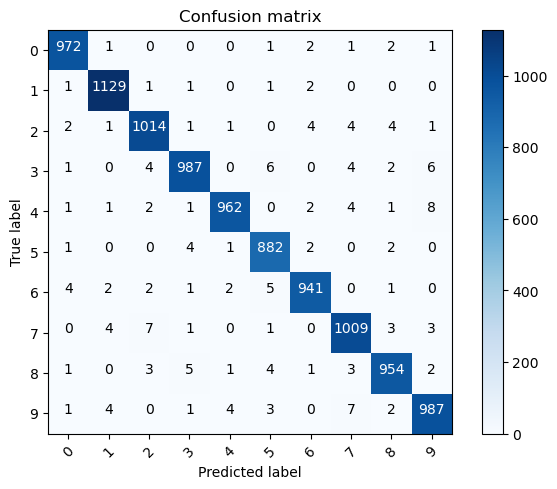

In [14]:
cm = metrics.confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

The code below gets used to investigate the errors

In [17]:
errors = (y_pred_classes - y_true != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = x_test[errors]

In [18]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-20:] # 5 last ones

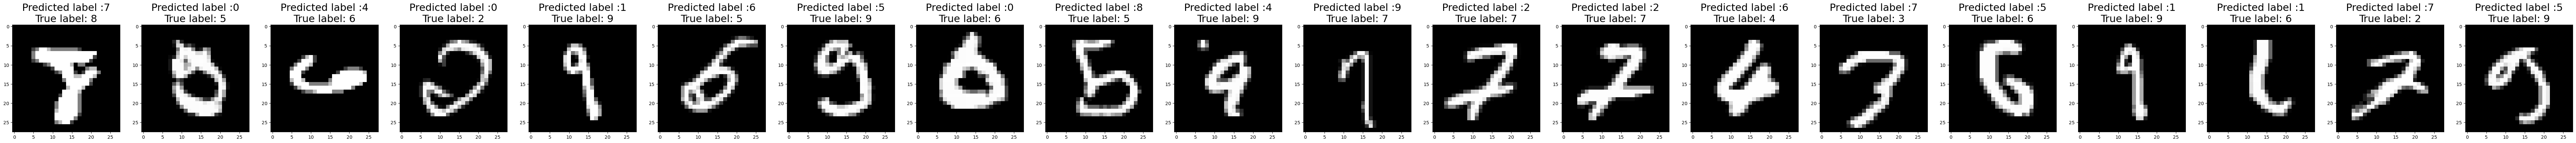

In [19]:
# Show Top Errors
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(100,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)

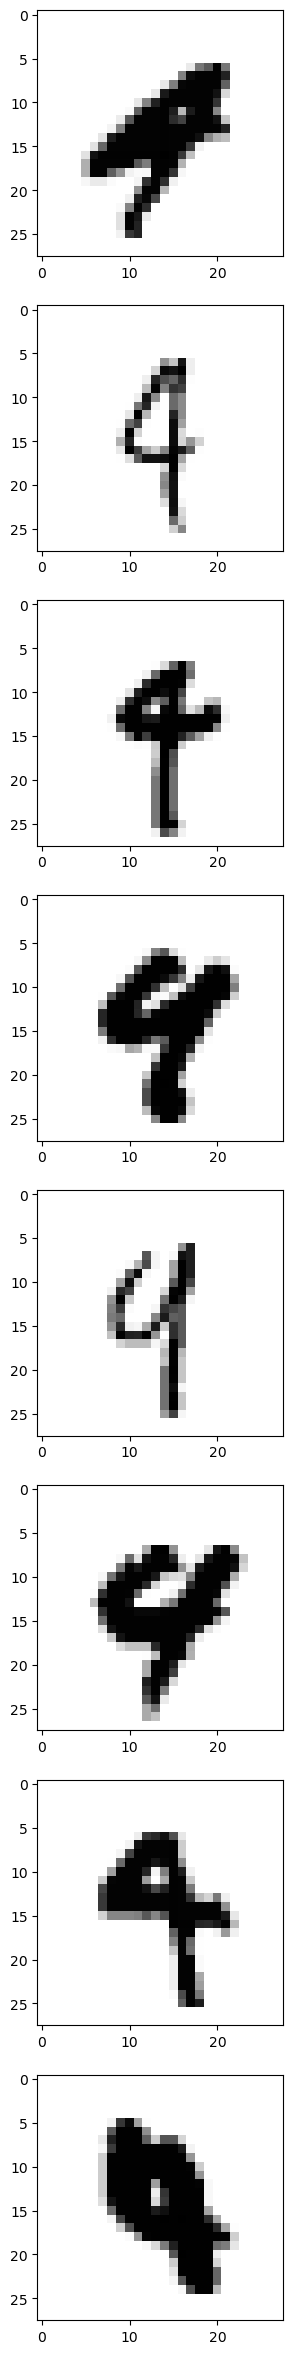

In [15]:
idx = np.where((y_pred_classes == 9) & (y_true == 4))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()

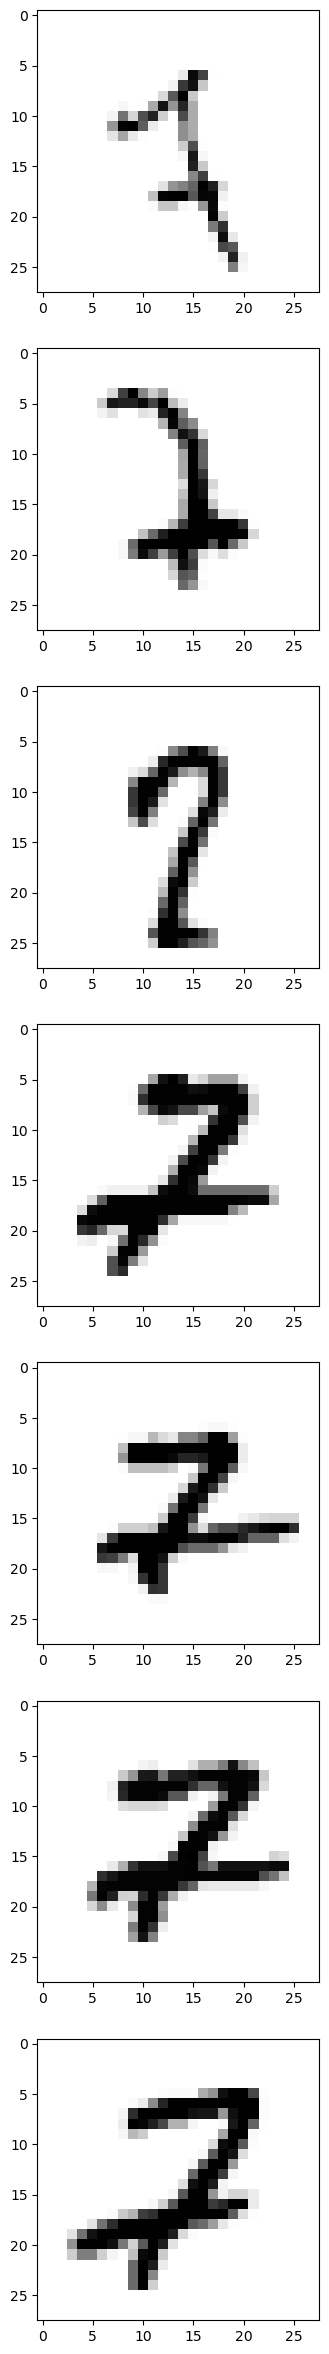

In [16]:
idx = np.where((y_pred_classes == 2) & (y_true == 7))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()

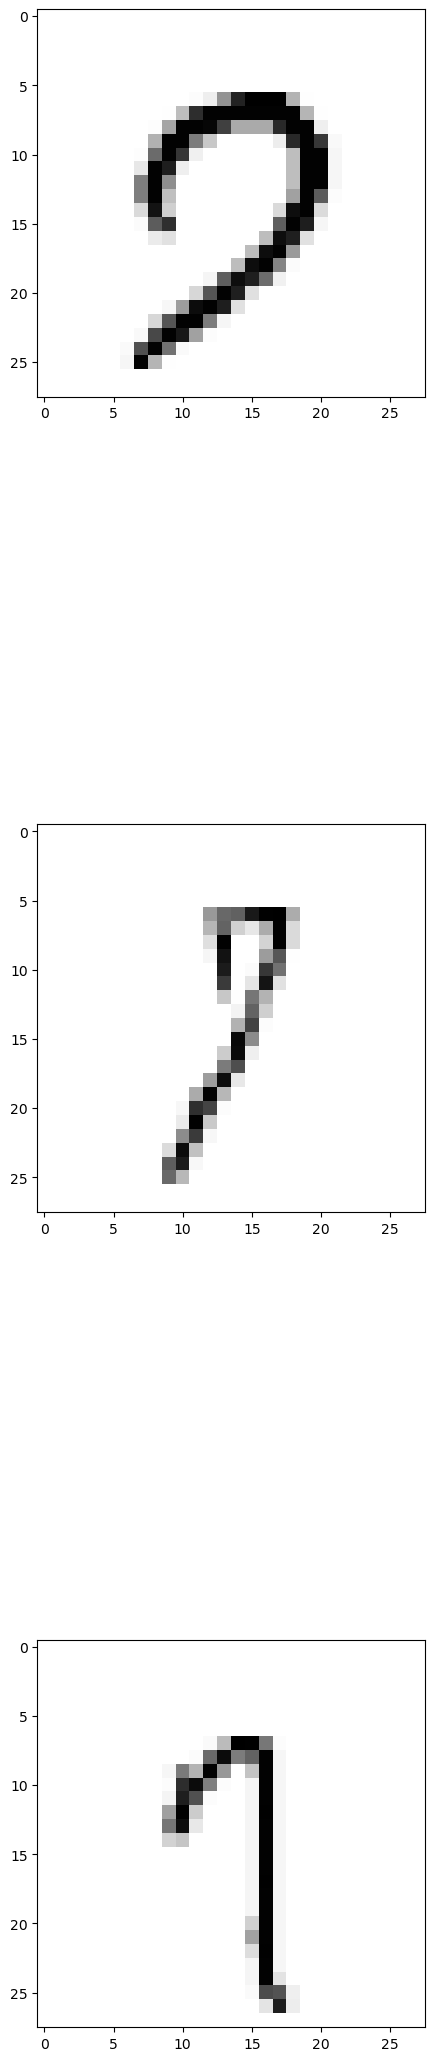

In [56]:
idx = np.where((y_pred_classes == 9) & (y_true == 7))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()

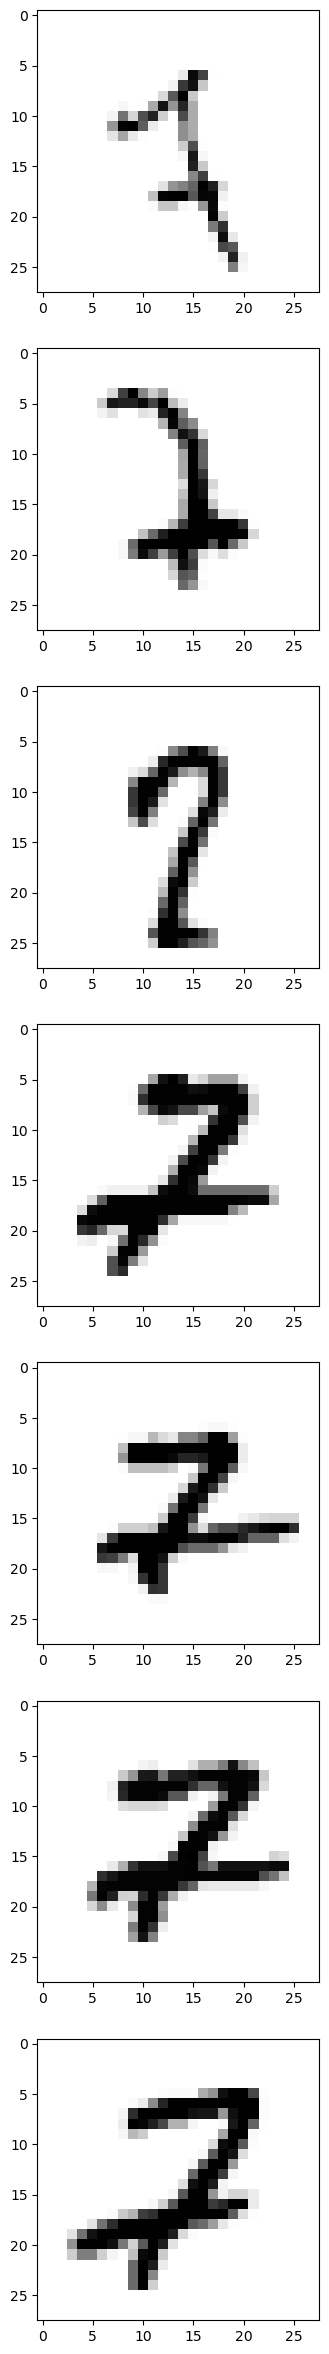

In [57]:
idx = np.where((y_pred_classes == 2) & (y_true == 7))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()